In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm  as cm
import matplotlib.colors as colors
G = 6.67e-11 #m3/kg/s2
g = 9.81 #m/s2
earth_m = 5.9e24 #kg
moon_m = 7.3e22 #kg
apollo_cmd_m = 5500 #kg
earth_rad = 6378 #km
moon_rad =  1737 #km
dist_e_m =  3.8e8 #m
stg1_exhaust_vel = 2.4e3 #m/s
s1c_burn_rate = 1.3e4 #kg/s
s1c_wet_m = 2.8e6 #kg
s1c_dry_m = 7.5e5 #kg

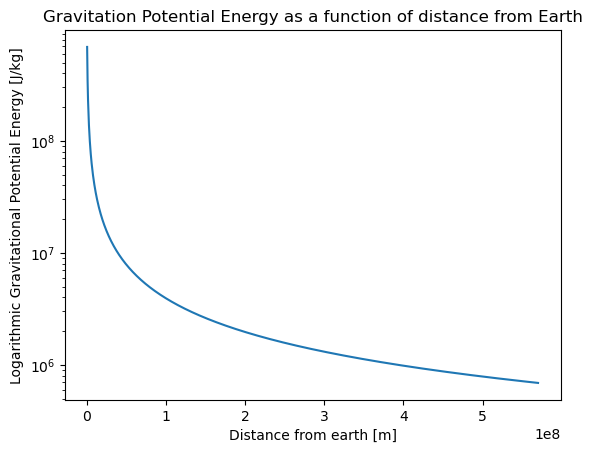

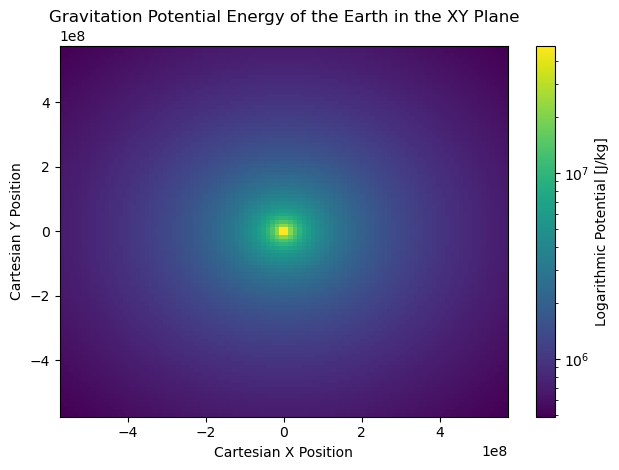

In [2]:
def gravpot(m,x,y,x0=0,y0=0):
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    #print(x,y,r)
    r = np.where(np.isclose(r,0), np.nan,r)
    pot = -G*m/r
    #pot = np.where(np.isclose(r,0), np.nan,(-G*m) / np.where(r == 0, np.inf, r))
    return pot

fig,ax = plt.subplots()
x = np.linspace(0,1.5*dist_e_m,1000)
y = np.zeros(1000)
ax.plot(x,np.abs(gravpot(earth_m,x,y)))
ax.set_yscale("log")
ax.set_xlabel("Distance from earth [m]")
ax.set_ylabel("Logarithmic Gravitational Potential Energy [J/kg]")
ax.set_title("Gravitation Potential Energy as a function of distance from Earth")
fig2,ax2 = plt.subplots()
x2 = np.linspace(-1.5*dist_e_m,1.5*dist_e_m,100)
y2 = x2.copy()
X,Y = np.meshgrid(x2,y2)
Z = np.abs(gravpot(earth_m,X,Y))
potential = ax2.pcolormesh(X,Y,Z, norm = colors.LogNorm(Z.min(),Z.max()));
cbar = fig2.colorbar(potential)
cbar.set_label("Logarithmic Potential [J/kg]")
ax2.set_xlabel("Cartesian X Position")
ax2.set_ylabel("Cartesian Y Position")
ax2.set_title("Gravitation Potential Energy of the Earth in the XY Plane")
fig2.tight_layout()
#cbar.ax2.set_yscale("log")

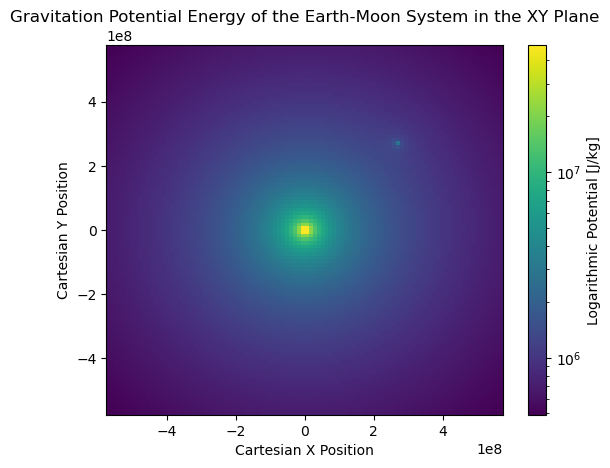

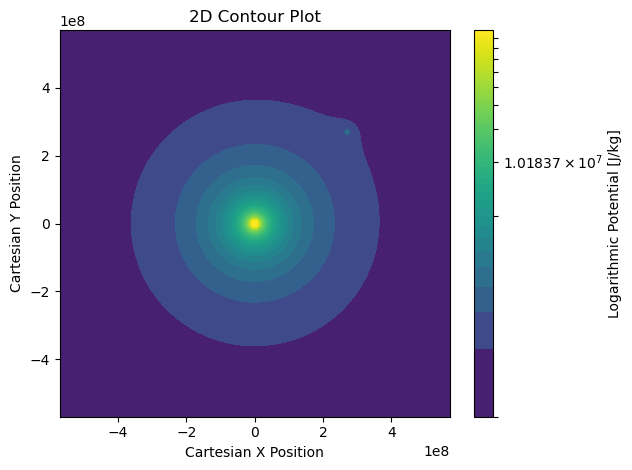

In [3]:
fig3,ax3 = plt.subplots()
phisum = np.abs(gravpot(earth_m,X,Y)) + np.abs(gravpot(moon_m,X,Y,dist_e_m/np.sqrt(2),dist_e_m/np.sqrt(2)))
earthmoonpot = ax3.pcolormesh(X,Y,phisum, norm = colors.LogNorm(phisum.min(),phisum.max()));
cbar2 = fig3.colorbar(earthmoonpot)
cbar2.set_label("Logarithmic Potential [J/kg]")
ax3.set_xlabel("Cartesian X Position")
ax3.set_ylabel("Cartesian Y Position")
ax3.set_title("Gravitation Potential Energy of the Earth-Moon System in the XY Plane")
fig4,ax4 = plt.subplots()
levels = np.linspace(phisum.min(),phisum.max(),80)
norm = colors.LogNorm(phisum.min(),phisum.max())
contour = ax4.contourf(X,Y,phisum,levels = levels,norm = norm)
cbar3 = fig4.colorbar(contour)
cbar3.set_label("Logarithmic Potential [J/kg]")
ax4.set_xlabel("Cartesian X Position")
ax4.set_ylabel("Cartesian Y Position")
ax4.set_title("2D Contour Plot")
fig4.tight_layout()

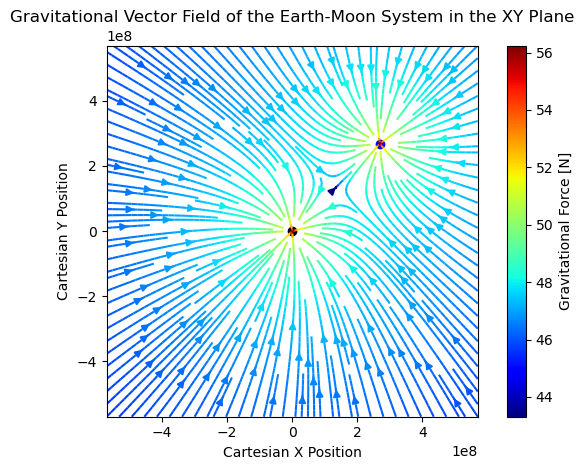

In [4]:

fig4,ax4 = plt.subplots(1,1)


ax4.plot([0],[0], "ko")
ax4.plot([dist_e_m/np.sqrt(2)],[dist_e_m/np.sqrt(2)],"bo")


ny = 200
y = np.linspace(-1.5*dist_e_m,1.5*dist_e_m,ny)
x = y.copy()
x_grid,y_grid = np.meshgrid(x,y)


Fx = np.zeros((ny,ny))
Fy = np.zeros((ny,ny))

def gforce(M1,m2,x1,y1,x2,y2):
    if np.isclose(x1,x2) and np.isclose(y1,y2):
       Fx = np.nan
       Fy = np.nan
    #elif np.isclose(x,dist_e_m/np.sqrt(2)) and np.isclose(y,dist_e_m/np.sqrt(2)):
       # Fx = np.nan
        #Fy = np.nan
    else:
        r_squared = ((x2-x1)**2+(y2-y1)**2)
        vec_r = np.array([x2-x1,y2-y1])
        vec_r_hat = vec_r/np.linalg.norm(vec_r)
        Fx = (-G*M1*m2/r_squared)*vec_r_hat[0] # x component
        Fy = (-G*M1*m2/r_squared)*vec_r_hat[1] # y component
    return Fx,Fy
for y in range(ny):
    for x in range(ny):
        g1x, g1y = gforce(earth_m,moon_m,0,0, x_grid[y,x], y_grid[y,x])
        g2x, g2y = gforce(earth_m,moon_m,dist_e_m/np.sqrt(2),dist_e_m/np.sqrt(2), x_grid[y,x], y_grid[y,x])

        Fx[y,x] += (g1x + g2x)
        Fy[y,x] += (g1y + g2y)
        

colors = np.log(np.hypot(Fx,Fy))
import matplotlib.cm as cm
stream = ax4.streamplot(x_grid,y_grid,Fx,Fy,color = colors, density=2, cmap = cm.jet)
cbar4 = fig4.colorbar(stream.lines)
ax4.set_aspect("equal")
ax4.set_xlabel("Cartesian X Position")
ax4.set_ylabel("Cartesian Y Position")
ax4.set_title("Gravitational Vector Field of the Earth-Moon System in the XY Plane")
cbar4.set_label("Gravitational Force [N]")
fig4.tight_layout()

In [5]:
from scipy.integrate import quad
T = (s1c_wet_m-s1c_dry_m)/s1c_burn_rate
print(f"This is the total burn time for the first stage of the Saturn V: {T} seconds")
def delv(ve,m0,mf,burnrate,t,g): 
    if m0==mf:
        vel_change = 0
    else: 
        vel_change = ve*np.log(m0/(m0-burnrate*t))-g*t
    return vel_change
altitude, err = quad(lambda t: delv(stg1_exhaust_vel,s1c_wet_m,s1c_dry_m,s1c_burn_rate,t,g),0,T)
print(f"This is the projected altitude for the Saturn V Rocket: {altitude} meters") #units of length

This is the total burn time for the first stage of the Saturn V: 157.69230769230768 seconds
This is the projected altitude for the Saturn V Rocket: 74093.98013366401 meters
